## Importing Libraries and Setting Up Paths


In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define data directories


train_fractured_dir = r"../Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured"
train_nonfractured_dir = r"../Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured"
test_fractured_dir = r"../Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured"
test_nonfractured_dir = r"../Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured"
val_fractured_dir = r"../Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured"
val_nonfractured_dir = r"../Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured"



## Exploratory Data Analysis


### Checking Dataset Balance


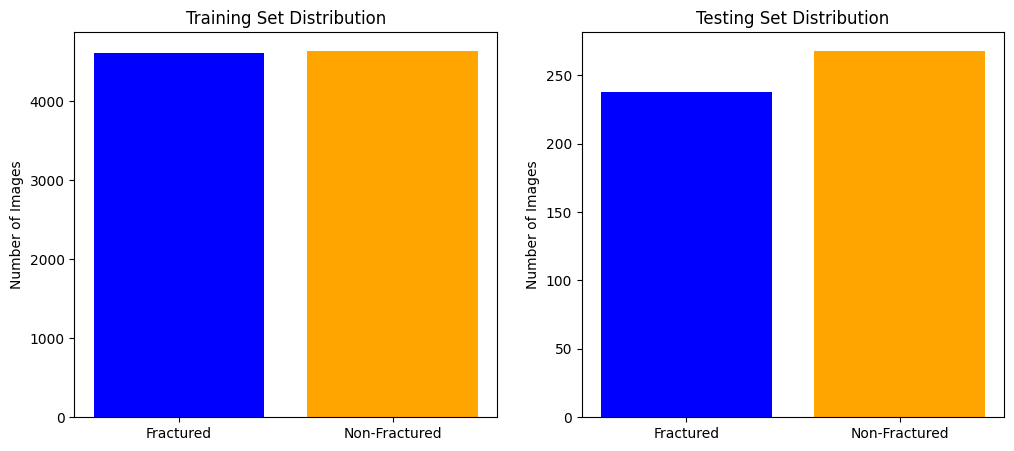

In [24]:
# Initialize counters
fractured_train_count = len(os.listdir(train_fractured_dir))
nonfractured_train_count = len(os.listdir(train_nonfractured_dir))
fractured_test_count = len(os.listdir(test_fractured_dir))
nonfractured_test_count = len(os.listdir(test_nonfractured_dir))

# Plot distribution
categories = ['Fractured', 'Non-Fractured']
train_counts = [fractured_train_count, nonfractured_train_count]
test_counts = [fractured_test_count, nonfractured_test_count]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].bar(categories, train_counts, color=['blue', 'orange'])
axs[0].set_title('Training Set Distribution')
axs[0].set_ylabel('Number of Images')

axs[1].bar(categories, test_counts, color=['blue', 'orange'])
axs[1].set_title('Testing Set Distribution')
axs[1].set_ylabel('Number of Images')

plt.show()


### Checking Aspect Ratio Distribution


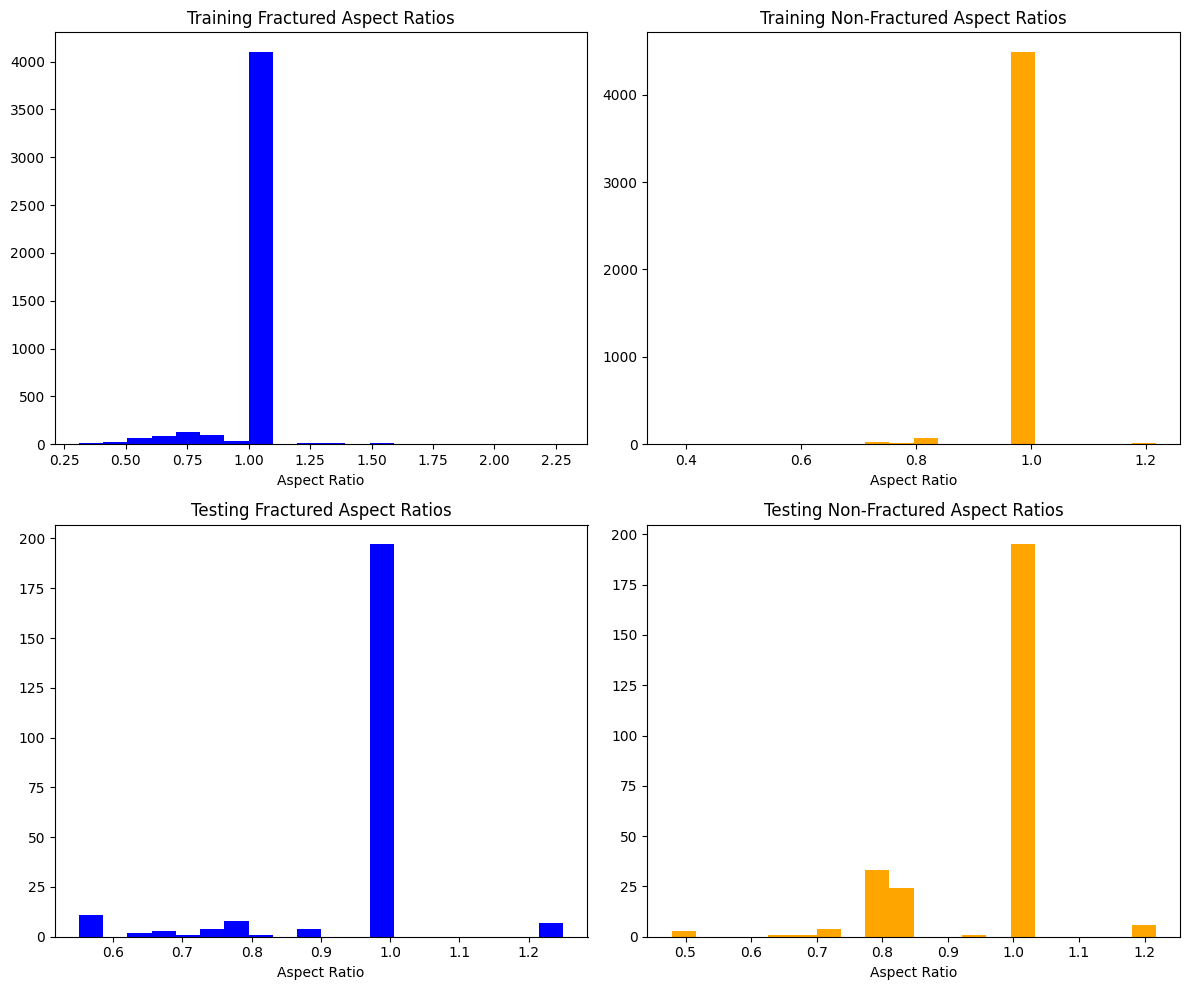

In [25]:


def get_aspect_ratios(image_dir):
    aspect_ratios = []
    for image_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_name)
        with Image.open(image_path) as img:
            width, height = img.size
            aspect_ratios.append(width / height)
    return aspect_ratios

# Collect aspect ratios
train_fractured_ratios = get_aspect_ratios(train_fractured_dir)
train_nonfractured_ratios = get_aspect_ratios(train_nonfractured_dir)
test_fractured_ratios = get_aspect_ratios(test_fractured_dir)
test_nonfractured_ratios = get_aspect_ratios(test_nonfractured_dir)

# Plot aspect ratio distributions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

axs[0].hist(train_fractured_ratios, bins=20, color='blue')
axs[0].set_title('Training Fractured Aspect Ratios')
axs[0].set_xlabel('Aspect Ratio')

axs[1].hist(train_nonfractured_ratios, bins=20, color='orange')
axs[1].set_title('Training Non-Fractured Aspect Ratios')
axs[1].set_xlabel('Aspect Ratio')

axs[2].hist(test_fractured_ratios, bins=20, color='blue')
axs[2].set_title('Testing Fractured Aspect Ratios')
axs[2].set_xlabel('Aspect Ratio')

axs[3].hist(test_nonfractured_ratios, bins=20, color='orange')
axs[3].set_title('Testing Non-Fractured Aspect Ratios')
axs[3].set_xlabel('Aspect Ratio')

plt.tight_layout()
plt.show()


## Preprocessing and Loading the Dataset


In [26]:
# Define transformations
data_transform = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
])

train_dir = r"../Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/"
test_dir = r"../Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/"
val_dir = r"../Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/"
# Load datasets
#train_dataset_fractured = datasets.ImageFolder(train_fractured_dir, transform=data_transform)
#train_dataset_nonfractured = datasets.ImageFolder(train_nonfractured_dir, transform=data_transform)

# Combine fractured and non-fractured datasets
#train_dataset = torch.utils.data.ConcatDataset([train_dataset_fractured, train_dataset_nonfractured])


train_dataset = datasets.ImageFolder(train_dir, transform=data_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transform) #sometimes called the dev set
test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)


# Split into training and validation sets (80% train, 20% validation)
#train_size = int(0.8 * len(train_dataset))
#val_size = len(train_dataset) - train_size
#train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Defining the Model


In [27]:
# Load pretrained ResNet50V2 and modify for binary classification
resnet = models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)  # Adjust the last layer for binary classification

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training the Model


In [28]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')


Epoch 1/10, Loss: 0.2480, Accuracy: 89.86%
Epoch 2/10, Loss: 0.0987, Accuracy: 96.51%
Epoch 3/10, Loss: 0.0567, Accuracy: 98.03%
Epoch 4/10, Loss: 0.0522, Accuracy: 98.28%
Epoch 5/10, Loss: 0.0427, Accuracy: 98.55%
Epoch 6/10, Loss: 0.0321, Accuracy: 98.86%
Epoch 7/10, Loss: 0.0343, Accuracy: 98.84%
Epoch 8/10, Loss: 0.0364, Accuracy: 98.79%
Epoch 9/10, Loss: 0.0290, Accuracy: 99.05%
Epoch 10/10, Loss: 0.0310, Accuracy: 98.94%


## Evaluating and Visualizing Model Performance


C:\Users\wmym\AppData\Roaming\Python\Python312\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 92.04%


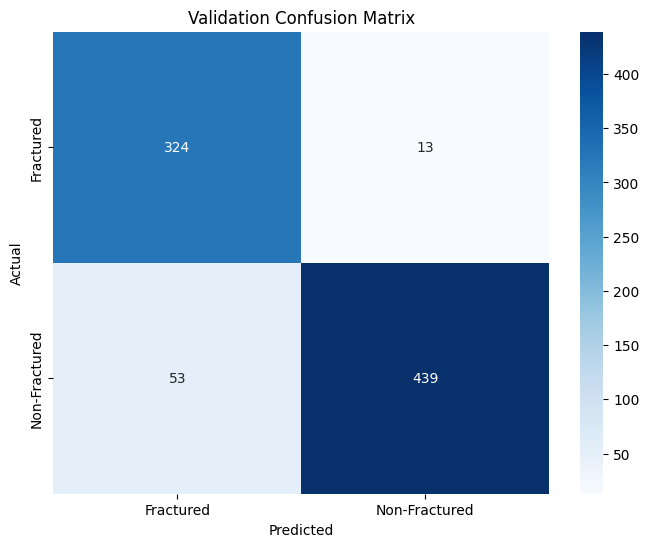

In [29]:
# Switch to evaluation mode
resnet.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f'Validation Accuracy: {val_acc:.2f}%')

# Plot confusion matrix (optional) or other visualizations
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()



## Advanced Visualization


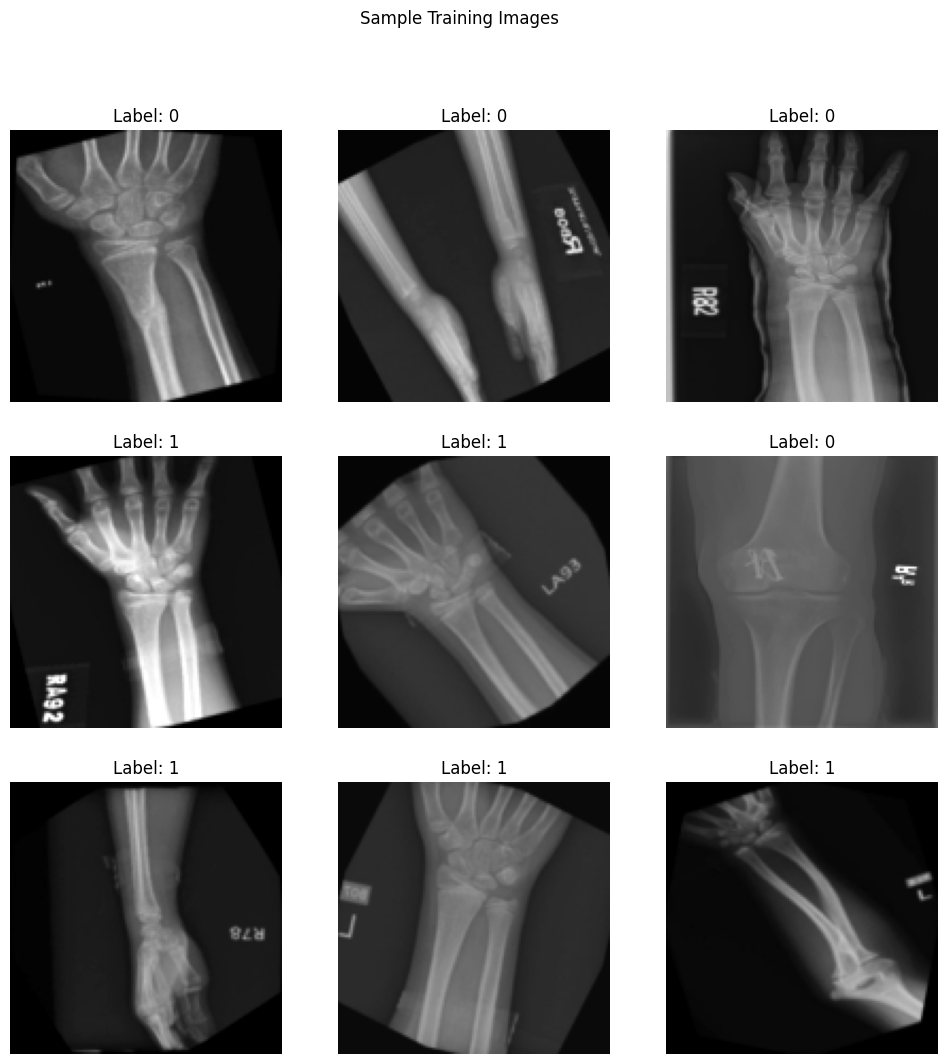

C:\Users\wmym\AppData\Roaming\Python\Python312\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


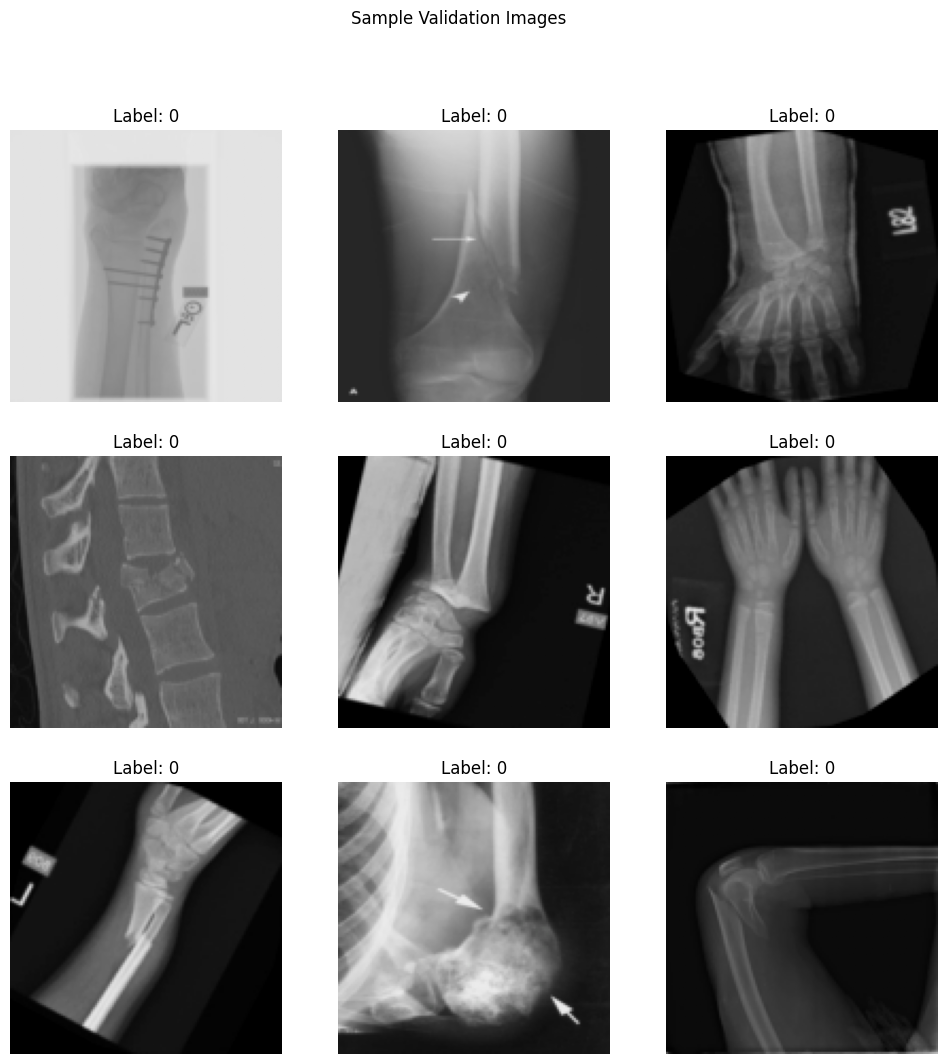

In [30]:
# Function to visualize sample images from a DataLoader
def visualize_batch(data_loader, title):
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs = axs.flatten()

    for i, (inputs, labels) in enumerate(data_loader):
        if i >= 9:
            break
        axs[i].imshow(inputs[0].permute(1, 2, 0).numpy())
        axs[i].axis('off')
        axs[i].set_title(f'Label: {labels[0].item()}')

    fig.suptitle(title)
    plt.show()

# Visualize batches
visualize_batch(train_loader, 'Sample Training Images')
visualize_batch(val_loader, 'Sample Validation Images')


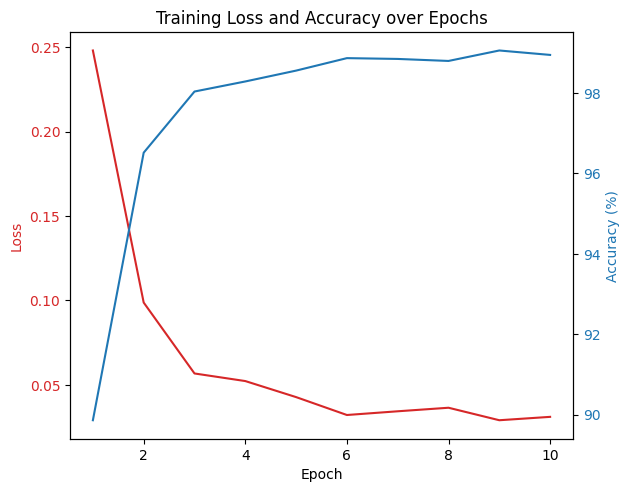

In [31]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
accuracy = [89.86, 96.51, 98.03, 98.28, 98.55, 98.86, 98.84, 98.79, 99.05, 98.94]
loss = [0.2480, 0.0987, 0.0567, 0.0522, 0.0427, 0.0321, 0.0343, 0.0364, 0.0290, 0.0310]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(epochs, accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Accuracy over Epochs')
plt.show()
